# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



In [1]:
import pickle

import numpy as np
from skimage import io
import math

import collections
import pandas as pd

from tqdm.autonotebook import tqdm, trange
from PIL import Image
from pathlib import Path
import os

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import cv2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import colors, pyplot as plt
%matplotlib inline

# # в sklearn не все гладко, чтобы в colab удобно выводить картинки
# # мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import torch

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

!nvidia-smi
torch.cuda.is_available()

CUDA is available!  Training on GPU ...
Mon Jan  9 12:10:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
# RESCALE_SIZE = 224
RESCALE_SIZE = 256 #Для VGG16
CENTER_CROP = 244
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\sigma} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [4]:
#Ячейка с аугментацией
from imgaug import augmenters as iaa

aug_pipeline = iaa.Sequential([
    # iaa.Sometimes(0.5, iaa.GaussianBlur((0, 3.0))), # apply Gaussian blur with a sigma between 0 and 3 to 50% of the images
    # # apply one of the augmentations: Dropout or CoarseDropout
    # iaa.OneOf([
    #     iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
    #     iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
    # ]),
    # apply from 0 to 3 of the augmentations from the list
    iaa.SomeOf((0, 3),[
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0.25))), # crop and pad 50% of the images
        iaa.Sometimes(0.5, iaa.Affine(rotate=5)) # rotate 50% of the images
    ])
],
random_order=True # apply the augmentations in random order
)

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, augmentations=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.augmentations = augmentations

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.CenterCrop(CENTER_CROP),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = np.array(x)
        if self.augmentations: x = self.augmentations.augment_image(x)
        x = np.array(x / 255, dtype='float32')
        
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [29]:
# !cp -R ../input/journey-springfield ../working/journey-springfield

In [ ]:
""" Ячейка для кагла (вставить в нижнюю)

TRAIN_DIR = Path('../working/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../working/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

"""

In [72]:
TRAIN_DIR = Path('../working/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../working/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [73]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify = train_val_labels)

train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train', augmentations=aug_pipeline)
full_train_dataset = SimpsonsDataset(train_val_files, mode='train')

Нарисуем график распредления объектов по классам

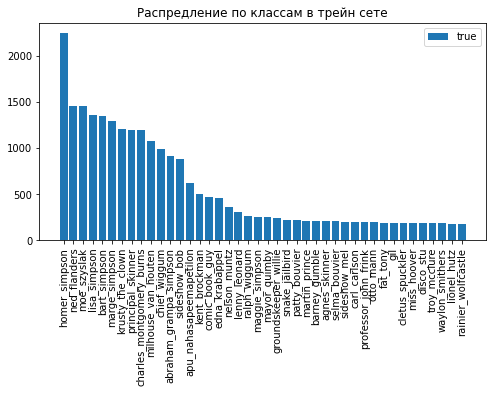

In [74]:
pd_true = pd.DataFrame(collections.Counter(train_val_labels).items()).sort_values(by=1,ascending=False)

plt.figure(figsize=(8,4))
plt.bar(x=pd_true[0],height=pd_true[1])
plt.xticks(rotation=90)
plt.legend(['true','pred'])
plt.title('Распредление по классам в трейн сете')
None

Судя по графику распредления, можно сделать вывод что датасет несбалансированный. (По крайней мере он таким был)
Для решения проблемы классового дисбаланса использовал оверсамплинг с аугментацией, а также WeightedRandomSampler.

In [75]:
statistics = pd.DataFrame(collections.Counter(train_val_labels).items())#.sort_values(by=1,ascending=False)
statistics[2] = 1 / statistics[1]

def count_weights_from_labels(labels, stats):
    buff = []
    for label in labels:
        buff.append(float(stats[2][stats[0]==label]))
    return buff

samples_train_weight = count_weights_from_labels(train_labels, statistics)
samples_val_weight = count_weights_from_labels(val_labels, statistics)

sampler_train_wht = torch.utils.data.WeightedRandomSampler(samples_train_weight, len(samples_train_weight), replacement=True)
sampler_val_wht = torch.utils.data.WeightedRandomSampler(samples_val_weight, len(samples_val_weight), replacement=True)

statistics.sort_values(by=1,ascending=False)

,0,1,2
15,homer_simpson,2246,0.000445
28,ned_flanders,1454,0.000688
27,moe_szyslak,1452,0.000689
20,lisa_simpson,1354,0.000739
4,bart_simpson,1342,0.000745
22,marge_simpson,1291,0.000775
17,krusty_the_clown,1206,0.000829
32,principal_skinner,1194,0.000838
6,charles_montgomery_burns,1193,0.000838
25,milhouse_van_houten,1079,0.000927


In [71]:
"""Ячейка оверсамплинга"""
# oversamling_value = 180 #значние до которого будем раздувать датасет
# for name in tqdm(statistics[0][statistics[1] < oversamling_value]):
#     count = int(statistics[1][statistics[0] == name]) # Достанем колличество элементов класса из statistics
#     items = sorted(list(TRAIN_DIR.rglob(f'*{name}/*.jpg')))# файлы с малым колличеством элементов (<100)
#     while count < oversamling_value:
#         for item in items:
#             count += 1
#             name = item.parent.name
#             image = Image.open(item)
#             image.load()
#             image = np.array(image)
#             image = aug_pipeline.augment_image(image)#используем агументацию
#             cv2.imwrite(str(item.parent)+f'/{count}_aug.jpg', image)

  0%|          | 0/21 [00:00<?, ?it/s]

In [66]:
"""Удалялка оверсамплинга"""
# files_to_del = sorted(list(TRAIN_DIR.rglob('*aug*.jpg')))
# for file in files_to_del:
#     os.remove(file)

После запуска ячейки оверсамплинга небходимо запустить ячейки с датасетом чтобы все заново прогрузить

Давайте посмотрим на наших героев внутри датасета.

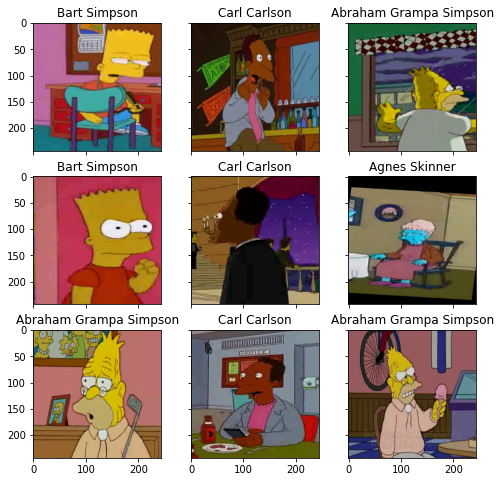

In [76]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [78]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [77]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [79]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [80]:
def train(train_dataset, val_dataset, model, opt, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler_train_wht)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, sampler=sampler_val_wht)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in trange(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [81]:
def predict(model, test_loader, train_predict=False):
    with torch.no_grad():
        logits = []
    
        for inputs in tqdm(test_loader):
            
            if train_predict: inputs = inputs[0]

            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [82]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify : {}".format(n_classes))
# print(simple_cnn)

we will classify : 42


Запустим обучение сети.

In [83]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [83]:
# inception = models.inception_v3(pretrained=True)
# inception.AuxLogits.fc = nn.Linear(768, n_classes)
# inception.fc = nn.Linear(2048, n_classes)
# # num_features -- это размерность вектора фич, поступающего на вход FC-слою 
# num_features = 25088
# inception = inception.cuda()
# inception.classifier = nn.Linear(num_features, n_classes)
# inception.aux_logits = False

In [84]:
vgg16 = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
# for param in vgg16.parameters():
#     param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
vgg16.classifier = nn.Linear(num_features, n_classes)

vgg16 = vgg16.cuda()

# Обучаем только классификатор
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [85]:
# history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)
history = train(train_dataset, val_dataset, model=vgg16, opt=optimizer, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

loss 0.8007742251928461

Epoch 001 train_loss: 0.8008 val_loss 0.6053 train_acc 0.7986 val_acc 0.8584
loss 0.11695249985895648

Epoch 002 train_loss: 0.1170 val_loss 0.4424 train_acc 0.9721 val_acc 0.8898
loss 0.06147790537512846

Epoch 003 train_loss: 0.0615 val_loss 0.3976 train_acc 0.9870 val_acc 0.9018
loss 0.03986571661780366

Epoch 004 train_loss: 0.0399 val_loss 0.4410 train_acc 0.9906 val_acc 0.8985
loss 0.024486404854891487

Epoch 005 train_loss: 0.0245 val_loss 0.3955 train_acc 0.9950 val_acc 0.9038


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

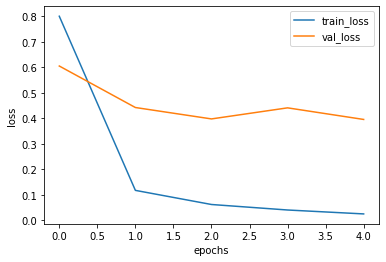

In [87]:
plt.figure(figsize=(6, 4))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [88]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(vgg16, ex_img.unsqueeze(0))

In [89]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(vgg16, imgs)

  0%|          | 0/20 [00:00<?, ?it/s]

In [90]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [91]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = label_encoder.fit_transform(y_pred)

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [92]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')

0.25

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

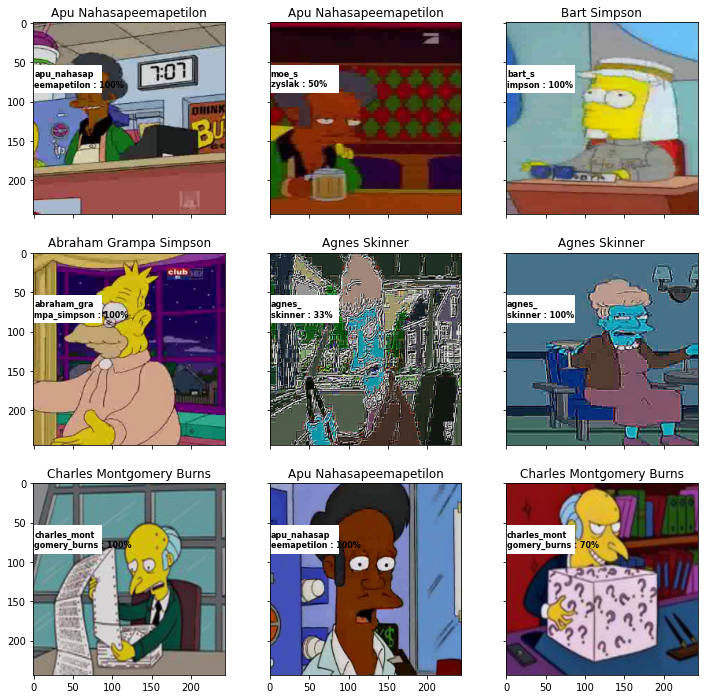

In [93]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))


    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(vgg16, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.inverse_transform([y_pred])[0]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

In [95]:
train_true = [i[1] for i in tqdm(full_train_dataset)]
train_probs = predict(vgg16, DataLoader(full_train_dataset,shuffle=False),train_predict=True)
train_probs = np.argmax(train_probs,-1)

  0%|          | 0/24035 [00:00<?, ?it/s]

  0%|          | 0/24035 [00:00<?, ?it/s]

График распредления и предикт по классам во всем трейн сете

0.967827126229201


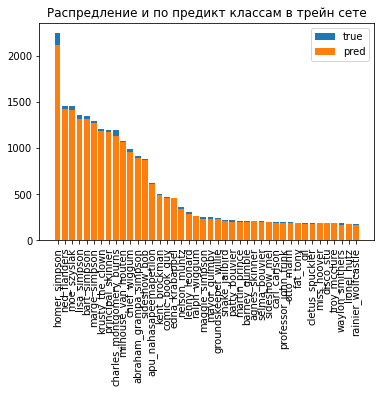

In [96]:
print(f1_score(train_true, train_probs, average='weighted'))
matrix = confusion_matrix(train_true, train_probs)
df_cm = pd.DataFrame(matrix, index = label_encoder.classes_, columns=label_encoder.classes_)

pd_true = pd.DataFrame(collections.Counter(train_val_labels).items()).sort_values(by=1,ascending=False)
pd_pred = pd.DataFrame({k:v for k,v in zip(label_encoder.classes_, matrix.diagonal())}.items()).sort_values(by=1,ascending=False)

for frame in [pd_true, pd_pred]:
    plt.bar(x=frame[0],height=frame[1])
plt.xticks(rotation=90)
plt.legend(['true','pred'])
plt.title('Распредление и предикт по классам в трейн сете')
None

Скор на simpleNN: 0.6791856669494728

vgg16: 0.9285296387700892

vgg16 oversampling + aug: 0.967827126229201

### Submit на Kaggle

In [97]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(vgg16, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

my_submit.to_csv('vgg16_aug_sampling.csv', index=False)

  0%|          | 0/16 [00:00<?, ?it/s]

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
